In [2]:
from PIL import Image

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

import cv2

from tqdm import tqdm

Using cache found in C:\Users\Sergi/.cache\torch\hub\pytorch_vision_v0.10.0


OrderedDict([('out', tensor([[[[ 9.3407,  9.3407,  9.3407,  ...,  8.2546,  8.2546,  8.2546],
          [ 9.3407,  9.3407,  9.3407,  ...,  8.2546,  8.2546,  8.2546],
          [ 9.3407,  9.3407,  9.3407,  ...,  8.2546,  8.2546,  8.2546],
          ...,
          [ 8.0901,  8.0901,  8.0901,  ...,  7.6140,  7.6140,  7.6140],
          [ 8.0901,  8.0901,  8.0901,  ...,  7.6140,  7.6140,  7.6140],
          [ 8.0901,  8.0901,  8.0901,  ...,  7.6140,  7.6140,  7.6140]],

         [[ 0.7425,  0.7425,  0.7425,  ..., -0.7933, -0.7933, -0.7933],
          [ 0.7425,  0.7425,  0.7425,  ..., -0.7933, -0.7933, -0.7933],
          [ 0.7425,  0.7425,  0.7425,  ..., -0.7933, -0.7933, -0.7933],
          ...,
          [-0.6410, -0.6410, -0.6410,  ..., -0.3421, -0.3421, -0.3421],
          [-0.6410, -0.6410, -0.6410,  ..., -0.3421, -0.3421, -0.3421],
          [-0.6410, -0.6410, -0.6410,  ..., -0.3421, -0.3421, -0.3421]],

         [[-3.0241, -3.0241, -3.0241,  ..., -1.9706, -1.9706, -1.9706],
         

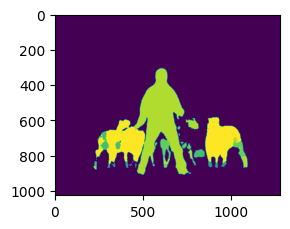

In [25]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
#print(model.eval())

# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
    print(output)
    output = output['out']
    print(output.shape)
    aux = output.squeeze()
    output = output[0]
    print(output.shape, aux.shape)

output_predictions = output.argmax(0)
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(output.argmax(0).byte().cpu().numpy())
#plt.imshow(r)

# FCN

Avui farem feina amb xarxes que no tenen cap tipus de capa _fully connected_ per tant serà una xarxa _Fully Convolutional Network_ (FCN). Quan parlam d'una xarxa FCN, ens referim a xarxes tipus VGG. Ens anirà molt bé fer aquesta pràctica per poder passar a xarxes que fan segmentació ja que la meitat d'aquestes és una FCN.

Emprarem un dataset propi per fer aquesta pràctica. Això implica fer una mica més de feina per preparar les dades. En concret emprarem una versió del conjunt de dades : AIXI_SHAPE propi d'en Miquel Miró. [Enllaç](https://uibes-my.sharepoint.com/:u:/g/personal/gma040_id_uib_eu/EcsNAK5mkXRBqayDo1JYeooBWCf1lpRA-YJHT_kDF4J_nA?e=apkCql)

La feina d'avui és "lliure" (considerau-ho una mini-pràctica), el conjunt de dades que teniu a la vostra disposició permet fer com a mínim 4 feines:

1. **Regressió**: Contar quants d'objectes hi ha
2. **Regressió de classe**: Contar quants d'objectes de cada classe hi ha en una imatge.
3. **Detecció**: Mostrar on hi ha cada un dels objectes. Es podrien emprar xarxes ja fetes per aquesta tasca (tant les que teniu disponibles a pytorch com altres que trobeu)
4. **Segmentació**: Encara no en sabem, però ho resoldrem la setmana que vé.

Avui heu de fer una de les dues primeres. Tant podeu triar fer-ho amb les imatges amb textura, com amb les imatges binaries que serveixen com a _ground truth_ (gt).

Les imatges del gt són imatges binàries (0,1) de 3 canals on a cada canal hi ha un tipus d'objecte . Per poder contar el nombre d'objectes possiblement haureu de emprar les funcions `cv2.add` per unir tots els canals en una sola imatge i la funció `cv2.findContours` per contar el nombre d'objectes en una imatge. A més podeu demanar-me ajuda a mi o al vostre amic ChatGPT.


#### [Inciso] Si emprau Colab:

Aquest codi us serveix per connectar colab amb google drive:

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# %ls
# %cd #TODO al vostre sistema de fitxers


## Preparació de les Dades
Per preparar el conjunt de dades necessitarem fer algunes pases:

1. Crear una llista amb les imatges 
2. Crear una classe que ens permeti obtenir una tupla (imatge, etiqueta)
3. Emprar els objectes DataLoader com hem fet sempre, aquí no trobareu cap canvi

#### Crear una llista amb les imatges 


In [36]:
import os

path_train = os.path.join(os.getcwd(), "data", "aixi_shape_256_texture", "train")

files = os.listdir(path_train)

img_files = [os.path.join(path_train, p) for p in files if p.endswith(".png")]
label_files = [os.path.join(path_train, "gt", p) for p in files if p.endswith(".png")]

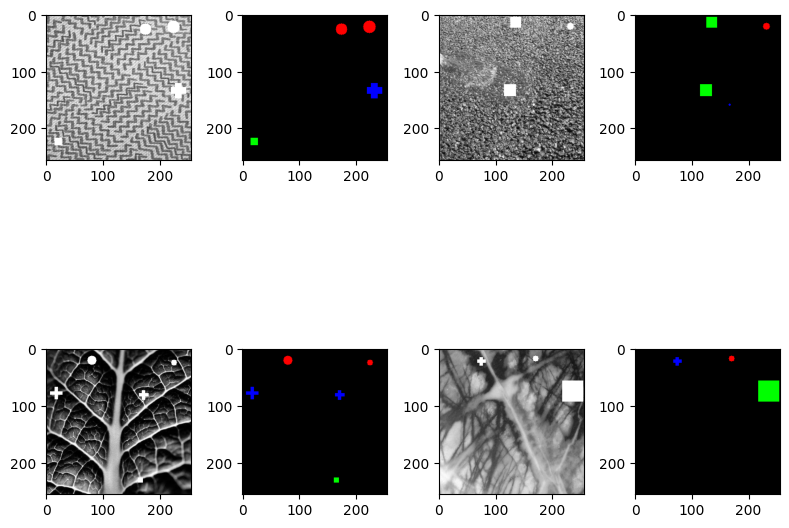

In [37]:
import random

random.seed(42)

plt.figure(figsize=(8, 8))
for i in range(4):
    rand_num = random.randint(0, len(img_files))
    img = cv2.imread(img_files[rand_num])
    label = cv2.imread(label_files[rand_num])
    plt.subplot(2, 4, 2 * i + 1)
    plt.imshow(img)
    plt.subplot(2, 4, 2 * i + 2)
    # label is a binary image with 0s and 1s, so we multiply by 255 to get the actual label
    plt.imshow(label * 255)


plt.tight_layout()
plt.show()

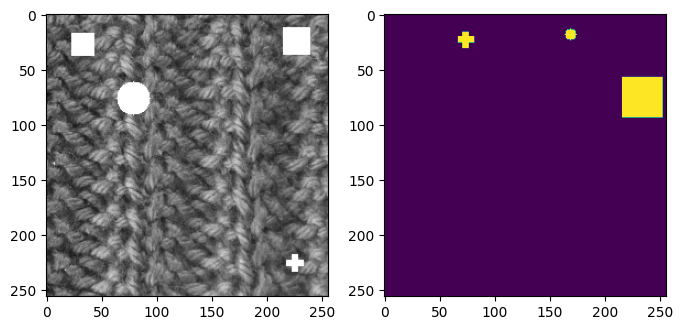

In [38]:
rand_num = random.randint(0, len(img_files))
img = cv2.imread(img_files[rand_num])
_label = cv2.imread(label_files[rand_num])
_label = cv2.add(label[:, :, 0], cv2.add(label[:, :, 1], label[:, :, 2]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(_label)
plt.show()

In [40]:
cont = cv2.findContours(_label, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Get the number of contours
n_contours = len(cont[0])
print(n_contours)

3


#### Crear una classe que ens permeti obtenir una tupla (imatge, etiqueta)

Aquesta classe hereta de la superclasse _Dataset_ i com a mínim ha de tenir els mètodes:

1. `__len__(self)`: retorna la longitud del dataset
2. `__getitem__(self, index)`: retorna l'element que es troba a la posició marcada pel valor d'index. Quan parlam d'un element parlam de la imatge i de la seva etiqueta.

El constructor i els atributs de la classe els he decidit jo:

- Llista amb els _paths_ a les imatges
- Llista amb els _paths_ a les imatges de gt que ens serviràn per calcular l'etiqueta de la imatge
- Un objecte transform

A la classe podeu afegir tants mètodes públics i privats com necessiteu

In [6]:
dataset = datasets.ImageFolder(path_train, transform=transforms.ToTensor())

mean, std = 0.0, 0.0
num_samples = len(dataset)

for data, _ in tqdm(dataset, total=num_samples):
    mean += data.mean(dim=(1, 2))
    std += data.std(dim=(1, 2))

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

100%|██████████| 10000/10000 [00:23<00:00, 419.88it/s]

Mean: tensor([1.9491e-05, 4.0427e-05, 3.6870e-05])
Std: tensor([0.0003, 0.0004, 0.0004])


In [52]:
# Constructor del dataset.
class AIXI_Shape(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths[index]
        label_path = self.labels[index]
        image = cv2.imread(path)
        label = cv2.imread(label_path)
        label = cv2.add(label[:, :, 0], cv2.add(label[:, :, 1], label[:, :, 2]))
        label = len(cv2.findContours(label, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0])
        if self.transform is not None:
            image = self.transform(image)

        return image, label


mean, std = [1.9491e-05, 4.0427e-05, 3.6870e-05], [0.0003, 0.0004, 0.0004]
# image normalization
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
        transforms.Normalize(mean=mean, std=std),
    ]
)


# creació dels conjunts d'entrenament i test
train_ds = AIXI_Shape(img_files, label_files, transform)
# El test l'heu de crear vosaltres
train_dl = DataLoader(train_ds, batch_size=64)
train_dl.dataset[0][0].shape, train_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 4)

In [53]:
# Test
path_train = os.path.join(os.getcwd(), "data", "aixi_shape_256_texture", "val")

test_files = os.listdir(path_train)

test_img_files = [os.path.join(path_train, p) for p in files if p.endswith(".png")]
test_label_files = [os.path.join(path_train, "gt", p) for p in files if p.endswith(".png")]

test_ds = AIXI_Shape(test_img_files, test_label_files, transform)
test_dl = DataLoader(test_ds, batch_size=64)
test_dl.dataset[0][0].shape, test_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 5)

## Xarxa
Com sempre, vosaltres us encarregau de dissenyar la xarxa:

In [81]:
# Ajuda: A la darrera capa convolucional estaría molt bé que: out_channels = al nombre de sortides de la xarxa
class TinyFCN(nn.Module):
    def __init__(self, num_classes=3):
        super(TinyFCN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = F.adaptive_avg_pool2d(x, 1).squeeze()
        return x


TinyFCN().eval()

TinyFCN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

# Entrenament

El blucle d'entrenament és el de sempre. Només heu de pensar quina funció de pèrdua heu d'emprar per el vostre/nostre problema

In [90]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    loss_v = 0

    for batch_idx, (data, target) in (t := tqdm(enumerate(train_loader), total=len(train_loader), disable=not verbose)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.float())

        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 and verbose:
            t.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
        loss_v += loss.item()
    loss_v /= len(train_loader.dataset)
    print("\nTrain set: Average loss: {:.4f}\n".format(loss_v))
    return loss_v


def test(model, device, test_loader, epoch, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader), disable=not verbose, desc=f"Testing: {epoch}"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target.float(), reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)  # obtener el índice de la probabilidad máxima
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )

    return test_loss

## Entrenament

In [91]:
torch.manual_seed(33)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device {device}")

epochs = 15
lr = 10e-4

model = TinyFCN(1).to(device)
#print(model)

opt_adam = optim.Adam(model.parameters(), lr=lr)
opt_sgd = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    optimizer = opt_adam if epoch < 10 else opt_sgd
    train_l[epoch] = train(model, device, train_dl, optimizer, epoch, log_interval=20)
    test_l[epoch] = test(model, device, test_dl, epoch)

Using device cuda


Train Epoch: 0 [0/10000 (0%)]	Loss: 1350.700439: 100%|██████████| 157/157 [00:31<00:00,  5.06it/s]



Train set: Average loss: 0.1351



Testing: 0:   0%|          | 0/157 [00:02<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Validació

Heu de fer vosaltres la validació depenent del problema que voldreu resoldre